In [36]:
# MNIST EXAMPLE 
# This notebook implements the examples from Lagaris 
# ["Lux", "NeuralPDE", "Zygote", "ModelingToolkit", "OrdinaryDiffEq", "LineSearches", "ProgressMeter", "Gnuplot", "Optimization", "OptimizationOptimJL", "OptimizationOptimisers"]
using Lux, NeuralPDE, Zygote
using ModelingToolkit
using ModelingToolkit: Interval
using OrdinaryDiffEq
using LineSearches
using MLDatasets, MLUtils, OneHotArrays
using ProgressMeter
using Gnuplot
#gpexec("load '~/gpconfig.cfg'")
import Base.show # this is needed otherwise the next line just defines a new function in a new module
show(io::IO, ::MIME"text/html", gp::Gnuplot.GPSession) = Gnuplot._show(io, gp, "svg enhanced standalone mouse size 400,250")
Gnuplot.options.verbose = false;
dump(Gnuplot.options) # print out the options

# https://julialang.slack.com/archives/C690QRAA3/p1711534935292689
# What is the relationship between Optimization.jl and Optimisers.jl?
# Optimization.jl is an interface over a whole set of optimization packages. It's the level of DifferentialEquations.jl, NonlinearSolve.jl, LinearSolve.jl, interfacing to tons (>10?) optimization packages.
# Optimisers.jl is a specific library of optimizers. Optimisers.jl is a specific library of optimizers.
# Optimization.jl has a wrapper for using Optimisers.jl methods (OptimizationOptimisers.jl), and that's the most common way things are trained with SciML applications like Neural ODEs.
# Optim.jl (OptimizationOptimJL.jl) is another Julia package implementing various algorithms to perform univariate and multivariate optimization
using Optimization, OptimizationOptimJL, OptimizationOptimisers
using Random, Statistics, ComponentArrays
# NN generator https://alexlenail.me/NN-SVG/

Gnuplot.Options
  dry: Bool false
  cmd: String "gnuplot"
  default: Symbol default
  term: String "qt 0 font \"Sans,9\""
  gpviewer: Bool false
  init: Array{String}((0,))
  verbose: Bool false
  preferred_format: Symbol auto


In [48]:
# load the datasets 
#MLDatasets.MNIST
# load full training set
function load_dataset() 
    train_dataset = MNIST(:train) # 60,000 
    test_dataset = MNIST(:test) # 10,000
    
    x_train = train_dataset.features # first image (first index is image id, second index is (features or label)
    y_train = train_dataset.targets # first image (first index is image id, second index is (features or label)
    #y_train = Flux.onehotbatch(y_train, 0:9)
    
    x_test = test_dataset.features # first image (first index is image id, second index is (features or label)
    y_test = test_dataset.targets # first image (first index is image id, second index is (features or label)
    #y_test = Flux.onehotbatch(y_test, 0:9)
    # flatten the images
    # each column is an image (28x28 = 784 pixels)
    x_train = MLUtils.flatten(x_train)
    x_test  = MLUtils.flatten(x_test)
    return x_train, x_test, y_train, y_test
end
x_train, x_test, y_train, y_test = load_dataset() # run the function to compile and test
println("x_train size: $(size(x_train)), y_train size: $(size(y_train))")

x_train size: (784, 60000), y_train size: (60000,)


28×28 transpose(::Matrix{Float32}) with eltype Float32:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  

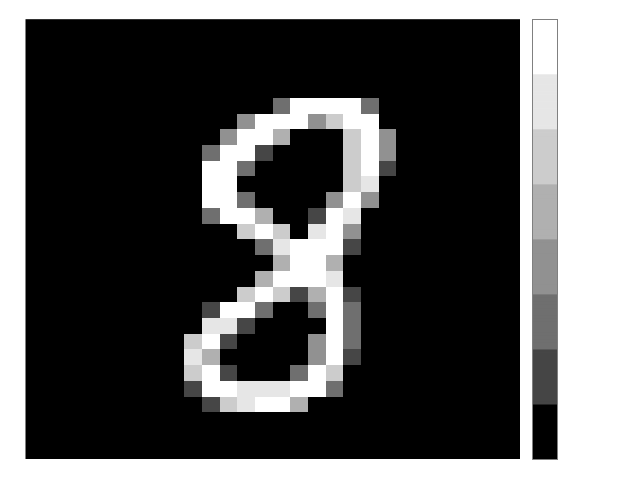

y label: 8


In [42]:
img_id = 564
img_px_data = transpose(reshape(x_test[:, img_id], (28, 28))) # the transpose + yaxis reverse in gnuplot makes figure right side up
display(img_px_data)
@gp "reset" 
@gp :- "load '~/gpconfig.cfg'"
@gp :- "unset border" "unset grid" "unset tics" "unset key"
@gp :- "set pm3d map"
@gp :- "set palette gray"
@gp :- "set yrange[*:*] reverse"
@gp :- img_px_data "with image notitle"
# plot 'data.dat' matrix nonuniform with image notitle
display(@gp)

println("y label: $(y_test[img_id])")

In [55]:
rng = MersenneTwister()
Random.seed!(rng, 12345)
model = Chain(Dense(784 => 10, relu), Dense(10 => 10), softmax) 
ps, st = Lux.setup(rng, model)
ps = ps |> ComponentArray
y_pred = model(x_train[:, 1], ps, st)[1] # forward pass

# onehotbatch y data 
y_ohb = onehotbatch(y_train, 0:9)
y_pred .- y_ohb[:, 1] # first image label

10-element Vector{Float32}:
  0.09317196
  0.13077097
  0.08434444
  0.12319594
  0.10387097
 -0.9155637
  0.101208374
  0.069571346
  0.09277656
  0.116653115

In [95]:
logitcrossentropy(y_pred, y) = mean(-sum(y .* logsoftmax(y_pred); dims=1))
function loss_function(model, ps, st, (x, y))
    y_pred, st = model(x, ps, st)
    return logitcrossentropy(y_pred, y), st, (;)
end
logitcrossentropy(y_pred, y_ohb[:, 1])

2.3183136f0

In [96]:
#opt = Descent(0.0001)  
opt = Optimisers.Adam(3.0f-4)
tstate = Lux.Experimental.TrainState(rng, model, opt; transform_variables=identity)
vjp_rule = AutoZygote() # Reverse AD library -- Vector Jacobian Product


### Warmup the model
x_proto = randn(rng, Float32, 784) # make a "single image"
y_proto = onehotbatch([1], 0:9) # make a single output vector
Lux.Experimental.compute_gradients(AutoZygote(), loss_function, (x_proto, y_proto), tstate)

((layer_1 = (weight = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.00727587 0.0009051554 … -0.0029218101 -0.006353114; 0.0 0.0 … 0.0 0.0], bias = Float32[0.0; 0.0; … ; 0.011206243; 0.0;;]), layer_2 = (weight = Float32[0.0 0.0 … 0.0052661044 0.0; 0.0 0.0 … -0.05910428 0.0; … ; 0.0 0.0 … 0.008011083 0.0; 0.0 0.0 … 0.0066665113 0.0], bias = Float32[0.0040280716; -0.04520918; … ; 0.0061277207; 0.0050992505;;]), layer_3 = nothing), 2.3567512f0, NamedTuple(), TrainState
    model: Chain()
    parameters: 7960
    states: 0
    optimizer_state: (layer_1 = (weight = Leaf(Adam(0.0003, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(0.0003, (0.9, 0.999), 1.0e-8), (Float32[0.0; 0.0; … ; 0.0; 0.0;;], Float32[0.0; 0.0; … ; 0.0; 0.0;;], (0.9, 0.999)))), layer_2 = (weight = Leaf(Adam(0.0003, (0.9, 0.999), 1.0e

In [99]:
function train_model(tstate::Lux.Experimental.TrainState, vjp, data, epochs)
    for epoch in 1:epochs
        grads, loss, stats, tstate = Lux.Experimental.compute_gradients(
            vjp, loss_function, data, tstate)
        if epoch % 500 == 1 || epoch == epochs
            println("Epoch: $epoch \t Loss: $loss")
        end
        tstate = Lux.Experimental.apply_gradients!(tstate, grads)
    end
    return tstate
end
tstate = train_model(tstate, vjp_rule, (x_train, y_ohb), 1000)

In [ ]:
y_pred = tstate.model(x, tstate.parameters, tstate.states)[1] # forward pass
